In [202]:
import numpy as np
import os
import yaml
import json
import matplotlib.pyplot as plt
from scipy.special import comb
import math
from scipy.interpolate import interp1d

In [203]:
def discretize_bezier(N, control_points):
    # Compute the Bezier curve for a given set of control points.
    control_points = np.array(control_points)
    n = len(control_points) - 1

    def bernstein_poly(i, n, t):
        return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

    t = np.linspace(0, 1, N)
    curve = np.zeros((N, control_points.shape[1]))

    for i in range(n + 1):
        curve += np.outer(bernstein_poly(i, n, t), control_points[i])

    return curve

def discretize_line(point1, point2, N):
    # Discretize a line given 2 points and N number of points.
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.linspace(point1, point2, N)

def geometricalLine(A, B, N, r):
    """
    Discretizes the line segment from A to B into N points with a geometric distribution clustered near B.
    
    Parameters:
    A (array-like): First point coordinates.
    B (array-like): Last point coordinates.
    N (int): Number of points.
    r (float): Ratio of geometric progression (>1).
    
    Returns:
    list: List of points along the line.
    """
    A = np.array(A)
    B = np.array(B)
    delta = B - A
    
    # Compute sum of geometric series
    if r == 1:
        S = N - 1
    else:
        S = (r**(N-1) - 1) / (r - 1)
    d = 1.0 / S
    
    # Generate t values
    t_values = [1.0]
    current_t = 1.0
    current_d = d
    for _ in range(N-2):
        current_t -= current_d
        t_values.append(current_t)
        current_d *= r
    # The last step should reach 0, but due to precision, we enforce it
    t_values.append(0.0)
    t_values = t_values[::-1]  # Reverse to go from 0 to 1
    
    # Compute points
    points = [A + t * delta for t in t_values]
    return points

In [204]:
def flatten_points_as_lists(nested_list):
    # Flattens a deeply nested list of lists into a single list of points, 
    # keeping points as lists.
    flat_points = []
    for item in nested_list:
        if isinstance(item, list):
            # If the item is a list, recursively process it
            if len(item) == 2 and all(isinstance(coord, (int, float)) for coord in item):
                # Append directly if it's a point-like structure
                flat_points.append(item)
            else:
                # Otherwise, recursively flatten the sublist
                flat_points.extend(flatten_points_as_lists(item))
    return flat_points

In [205]:
def interp_s(x, y, s_old, s_target):
    '''Interpolate x and y at s_target based on s_old'''
    i = 0
    while i < len(s_old) - 1 and not (s_old[i] <= s_target <= s_old[i+1]):
        i += 1
    if i == len(s_old) - 1:
        return x[-1], y[-1]
    seg_length = s_old[i+1] - s_old[i]
    if seg_length < 1e-14:
        return x[i], y[i]
    t = (s_target - s_old[i]) / seg_length
    xx = x[i] + t * (x[i+1] - x[i])
    yy = y[i] + t * (y[i+1] - y[i])
    return xx, yy


def curvature(points):
    ds_list = []
    x, y = np.array(points)[:, 0], np.array(points)[:, 1]
    for i in range(len(x)-1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        ds_list.append(math.sqrt(dx*dx + dy*dy))

    s = [0.0]
    for dist in ds_list:
        s.append(s[-1] + dist)

    L = s[-1]

    return s, L

In [206]:
def harmonize_points(points, delta, epsilon=0.0005, max_points=1000):
    '''Uniformly sample points along the curve'''
    s = curvature(points)[0]
    N = max_points


    s_new = [0 for i in range(N)]
    for j in range(1,N):
        s_new[j] = s_new[j-1] + delta

    x, y = np.array(points)[:, 0], np.array(points)[:, 1]
    npoints = []

    for val in s_new:
        xx, yy = interp_s(x, y, s, val)
        npoints.append([xx, yy])

    return npoints

In [207]:
def curvatureBased(x, y, num_points):
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Compute arc length
    dx = np.diff(x)
    dy = np.diff(y)
    ds = np.sqrt(dx**2 + dy**2)
    s = np.zeros(len(x))
    s[1:] = np.cumsum(ds)
    
    # Calculate curvature at each point
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    curvature = np.nan_to_num(curvature, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Compute weights for each segment (average curvature * segment length)
    avg_curvature = (curvature[:-1] + curvature[1:]) / 2
    weights = avg_curvature * ds
    total_weight = np.sum(weights)
    
    if total_weight <= 0:
        # Fallback to uniform sampling if all weights are zero
        s_targets = np.linspace(0, s[-1], num_points)
    else:
        # Compute cumulative weights
        cumulative_weights = np.zeros(len(s))
        cumulative_weights[1:] = np.cumsum(weights)
        
        # Generate target weights
        target_weights = np.linspace(0, total_weight, num_points)
        
        # Find corresponding segment indices and fractions
        indices = np.searchsorted(cumulative_weights, target_weights) - 1
        indices = np.clip(indices, 0, len(weights) - 1)
        
        # Calculate fraction within each segment
        valid = (cumulative_weights[indices + 1] > cumulative_weights[indices])
        remaining = target_weights - cumulative_weights[indices]
        segment_weights = cumulative_weights[indices + 1] - cumulative_weights[indices]
        fraction = np.divide(remaining, segment_weights, where=valid, out=np.zeros_like(remaining))
        fraction = np.clip(fraction, 0, 1)
        
        # Compute target arc lengths
        s_targets = s[indices] + fraction * (s[indices + 1] - s[indices])
    
    # Interpolate x and y at the target arc lengths
    f_x = interp1d(s, x, kind='linear', fill_value='extrapolate')
    f_y = interp1d(s, y, kind='linear', fill_value='extrapolate')
    x_resampled = f_x(s_targets)
    y_resampled = f_y(s_targets)
    
    return x_resampled, y_resampled


In [208]:
def resample_by_curvature(x, y, num_points, max_dist=None, min_dist=None):
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Calculate arc length
    dx = np.diff(x)
    dy = np.diff(y)
    ds = np.sqrt(dx**2 + dy**2)
    s = np.zeros(len(x))
    s[1:] = np.cumsum(ds)
    
    # Compute curvature
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    curvature = np.nan_to_num(curvature, 0) #replace NaN with 0
    
    # Calculate segment weights
    avg_curvature = (curvature[:-1] + curvature[1:]) / 2
    weights = avg_curvature * ds
    total_weight = np.sum(weights)
    
    # Generate target arc lengths
    if total_weight <= 0:
        s_targets = np.linspace(0, s[-1], num_points)
    else:
        cumulative_weights = np.insert(np.cumsum(weights), 0, 0)
        target_weights = np.linspace(0, total_weight, num_points)
        indices = np.clip(np.searchsorted(cumulative_weights, target_weights) - 1, 0, len(weights)-1)
        t_frac = (target_weights - cumulative_weights[indices]) / (cumulative_weights[indices+1] - cumulative_weights[indices])
        s_targets = s[indices] + t_frac * (s[indices+1] - s[indices])
    
    # Apply maximum and minimum distance constraints
    if (max_dist is not None and max_dist > 0) or (min_dist is not None and min_dist > 0):
        s_processed = [s_targets[0]]
        for current_s in s_targets[1:]:
            prev_s = s_processed[-1]
            delta_s = current_s - prev_s
            
            # Enforce maximum distance
            if max_dist is not None and delta_s > max_dist:
                n_segments = int(np.ceil(delta_s / max_dist))
                new_s = np.linspace(prev_s, current_s, n_segments + 1)[1:]
                s_processed.extend(new_s)
            
            # Enforce minimum distance
            elif min_dist is not None and delta_s < min_dist:
                # Skip this point if it's too close to the previous one
                continue
            
            else:
                s_processed.append(current_s)
        s_targets = np.array(s_processed)
    
    
    # Ensure s_targets are within the valid range of the original curve
    s_targets = np.clip(s_targets, 0, s[-1])
    
    # Interpolate new points
    f_x = interp1d(s, x, kind='linear', fill_value='extrapolate')
    f_y = interp1d(s, y, kind='linear', fill_value='extrapolate')
    return f_x(s_targets), f_y(s_targets)

In [209]:
def findN(L, alpha, beta):
    # Finding the number of points N for the geometrical law
    a = 1 - L/alpha * (1 - beta)
    if a <= 0 or beta == 1 :
        raise ValueError("Invalid values for alpha, beta and L")
    return round(1 + math.log(a) / math.log(beta))

In [210]:
# Geometrical law
def geometrical(points, alpha, beta):
    s = curvature(points)[0]
    L = curvature(points)[1]
    N = findN(L, alpha, beta)

    s_new = [0 for i in range(N)]
    for j in range(1,N):
        s_new[j] = s_new[j-1] + alpha*(beta**(N-j-1))

    x, y = np.array(points)[:, 0], np.array(points)[:, 1]
    npoints = []

    for val in s_new:
        xx, yy = interp_s(x, y, s, val)
        npoints.append([xx, yy])

    return npoints

In [211]:
def findN(L, alpha, beta):
    # Finding the number of points N for the geometrical law
    a = 1 - L/alpha * (1 - beta)
    if a <= 0 or beta == 1 :
        raise ValueError("Invalid values for alpha, beta and L")
    return round(1 + math.log(a) / math.log(beta))

In [212]:
def harmonize(points, delta, epsilon=0.0005, max_points=1000):
    # Uniformly sample points along the curve
    s = curvature(points)[0]
    N = max_points


    s_new = [0 for i in range(N)]
    for j in range(1,N):
        s_new[j] = s_new[j-1] + delta

    x, y = np.array(points)[:, 0], np.array(points)[:, 1]
    npoints = []

    for val in s_new:
        xx, yy = interp_s(x, y, s, val)
        npoints.append([xx, yy])

    return npoints

In [213]:
def main(path : str):
    # Number of points discretized
    t = 1000
    discretized_points = []


    with(open(path, 'r')) as f:
        data = json.load(f)

    N = data['N']
    curves = data['curves']
    types = [curves[i]['type'] for i in range(len(curves))]

    for i in range(N):
        aux = []
        if types[i] == 'bezier':
            # Extracting control points
            control_points = []
            point1 = [data['x_ref'][i], data['y_ref'][i]]
            point2 = [data['x_ref'][i+1], data['y_ref'][i+1]]

            control_points.append(point1)
            xref = curves[i]['x_ctr']
            yref = curves[i]['y_ctr']
            n = len(xref)
            for j in range(n):
                control_points.append([xref[j], yref[j]])
            control_points.append(point2)
            
            # Discretizing the Bezier curve
            points = discretize_bezier(t, control_points)
            #aux_points.append(points.tolist())
            flatAuxPoints = flatten_points_as_lists(points.tolist())
            x,y = np.array(flatAuxPoints)[:,0], np.array(flatAuxPoints)[:,1]
            xn, yn = resample_by_curvature(x, y, num_points=150, max_dist=None, min_dist=0.01)
            print(zip(xn, yn))
            discretized_points.append(np.array([xn, yn]).T.tolist())

        elif types[i] == 'droite':
            if i < N - 1 and types[i+1] == 'droite':
                # Discretizing the line
                point1 = [data['x_ref'][i], data['y_ref'][i]]
                point2 = [data['x_ref'][i+1], data['y_ref'][i+1]]
                points = geometricalLine(point1, point2, 50, r=1.2)
                for p in points:
                    discretized_points.append(p.tolist())
                aux = []
            elif i > 0 and types[i-1] == 'droite':
                point1 = [data['x_ref'][i], data['y_ref'][i]]
                point2 = [data['x_ref'][i+1], data['y_ref'][i+1]]
                points = geometricalLine(point2, point1, 50, r=1.2)
                for p in points:
                    discretized_points.append(p.tolist())
                aux = []
            else:
                # Discretizing the line
                point1 = [data['x_ref'][i], data['y_ref'][i]]
                point2 = [data['x_ref'][i+1], data['y_ref'][i+1]]
                points = discretize_line(point1, point2, t)
                aux.append(points.tolist())
                flatAuxPoints = flatten_points_as_lists(aux)
                newPoints = harmonize(flatAuxPoints, 0.02)
                discretized_points.append(newPoints)
                aux = []

    return discretized_points

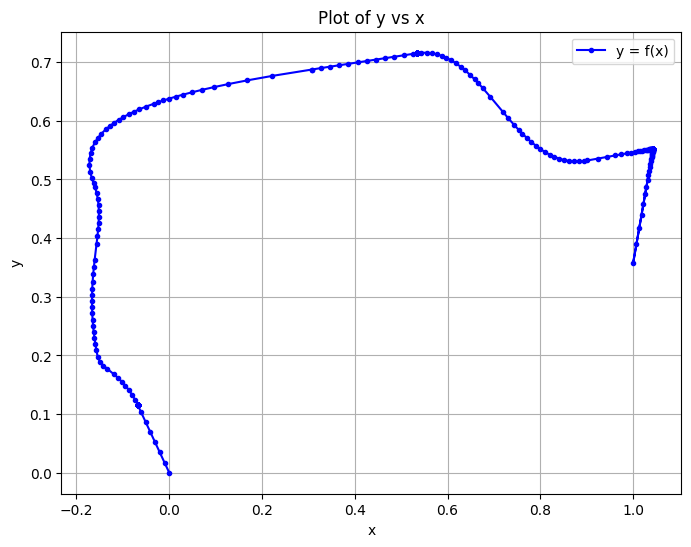

In [214]:
discretized_points = main('/home/hakim/PSC/tests/radone1/test.json')
flattened = flatten_points_as_lists(discretized_points)
x, y = np.array(flattened)[:,0], np.array(flattened)[:,1]
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(x, y, marker=".", linestyle="-", color="b", label="y = f(x)")  # Plot the curve
plt.title("Plot of y vs x")  # Add a title
plt.xlabel("x")  # Label the x-axis
plt.ylabel("y")  # Label the y-axis
plt.grid(True)  # Add a grid
plt.legend()  # Show the legend

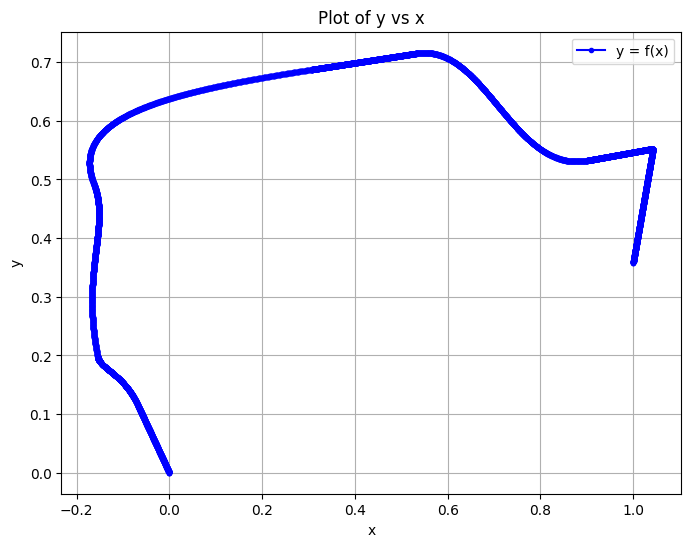

In [215]:
# Main Code

def mainold(path : str):
    # Number of points discretized
    t = 1000
    discretized_points = []


    with(open(path, 'r')) as f:
        data = json.load(f)

    N = data['N']
    curves = data['curves']
    types = [curves[i]['type'] for i in range(len(curves))]

    for i in range(N):
        if types[i] == 'bezier':
            # Extracting control points
            control_points = []
            point1 = [data['x_ref'][i], data['y_ref'][i]]
            point2 = [data['x_ref'][i+1], data['y_ref'][i+1]]

            control_points.append(point1)
            xref = curves[i]['x_ctr']
            yref = curves[i]['y_ctr']
            n = len(xref)
            for j in range(n):
                control_points.append([xref[j], yref[j]])
            control_points.append(point2)
            
            # Discretizing the Bezier curve
            points = discretize_bezier(t, control_points)
            discretized_points.append(points.tolist())

        elif types[i] == 'droite':
            # Discretizing the line
            point1 = [data['x_ref'][i], data['y_ref'][i]]
            point2 = [data['x_ref'][i+1], data['y_ref'][i+1]]
            points = discretize_line(point1, point2, t)
            discretized_points.append(points.tolist())

    return discretized_points

discretized_points = mainold('/home/hakim/PSC/tests/radone1/test.json')
flat = flatten_points_as_lists(discretized_points)
x, y = np.array(flat)[:,0], np.array(flat)[:,1]
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(x, y, marker=".", linestyle="-", color="b", label="y = f(x)")  # Plot the curve
plt.title("Plot of y vs x")  # Add a title
plt.xlabel("x")  # Label the x-axis
plt.ylabel("y")  # Label the y-axis
plt.grid(True)  # Add a grid
plt.legend()  # Show the legend
plt.show()